In [1]:
import json, os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATASETS = "/mount/studenten/semantic-plausibility/datasets/adept"
notebook_dir = Path(os.getcwd())

# Assuming the dataset is in /mount/studenten/semantic-plausibility/datasets/adept
dataset_dir = Path(DATASETS)

# Construct relative paths
train_path = dataset_dir / "train-dev-test-split" / "train.json"
val_path = dataset_dir / "train-dev-test-split" / "val.json"
test_path = dataset_dir / "train-dev-test-split" / "test.json"
concrete_path = notebook_dir / "concrete_13428_2013_403_MOESM1_ESM.xlsx"

In [3]:
def combine_data(train_path, val_path, test_path):
    """
    Combining the train/val/test datasets into a single dataset for data analysis.
    """

    with open(train_path, "r") as train_file:
        train_data = json.load(train_file)

    with open(val_path, "r") as val_file:
        val_data = json.load(val_file)

    with open(test_path, "r") as test_file:
        test_data = json.load(test_file)
    
    train_df = pd.DataFrame(train_data)
    val_df = pd.DataFrame(val_data)
    test_df = pd.DataFrame(test_data)
    train_df["dataset"] = "train"
    val_df["dataset"] = "val"
    test_df["dataset"] = "test"
    combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

    return combined_df

In [4]:
combined_df = combine_data(train_path, val_path, test_path)
combined_df.head()

,sentence1,sentence2,modifier,noun,label,idx,dataset
0,The effect of sleeping is rejuvenation.,The effect of additional sleeping is rejuvenat...,additional,sleeping,3,13484,train
1,A toothbrush is for fresh breath.,A regular toothbrush is for fresh breath.,regular,toothbrush,2,2620,train
2,A scene is painted.,A negative scene is painted.,negative,scene,2,3324,train
3,A bone breaks a tooth.,An alleged bone breaks a tooth.,alleged,bone,2,10610,train
4,A trip causes a happening.,A fabulous trip causes a happening.,fabulous,trip,2,14917,train


In [5]:
# Numbers of instances
instance_counts = len(combined_df)
instance_counts

16115

## 5-Class and 3-Class Label Distribution

In [6]:
# define label mappings for different numbers of labels
 
five_class_label = {
    0: "(0) Impossible",
    1: "(1) Less likely",
    2: "(2) Equally likely",
    3: "(3) More likely",
    4: "(4) Necessarily true"
}

three_class_label = {
    0: "(-1) Decrease in plausibility",
    1: "(-1) Decrease in plausibility",
    2: "(0) Equally likely",
    3: "(1) Increase in plausibility",
    4: "(1) Increase in plausibility"
}

In [7]:
def label_dstribution(df, label_mapping, title):
    df["label_strings"] = df["label"].map(label_mapping)
    label_counts = df["label_strings"].value_counts()
    label_proportions = label_counts / instance_counts
    label_stat = pd.DataFrame({"Label counts": label_counts,
                                "Label proportions": label_proportions})
    print(f"\n{label_stat}")
    
    # plot_label_distribution
    fig, ax = plt.subplots(figsize=(6, 6))
    bars = ax.bar(label_proportions.index, label_proportions, color="blue")

    for bar, proportion in zip(bars, label_proportions):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f"{proportion:.2f}", fontsize=10)
    plt.xlabel("Label")
    plt.ylabel("Proportion")
    plt.title(title)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.show()
    return None


                      Label counts  Label proportions
label_strings                                        
(2) Equally likely           10805           0.670493
(0) Impossible                2221           0.137822
(1) Less likely               1868           0.115917
(3) More likely               1132           0.070245
(4) Necessarily true            89           0.005523


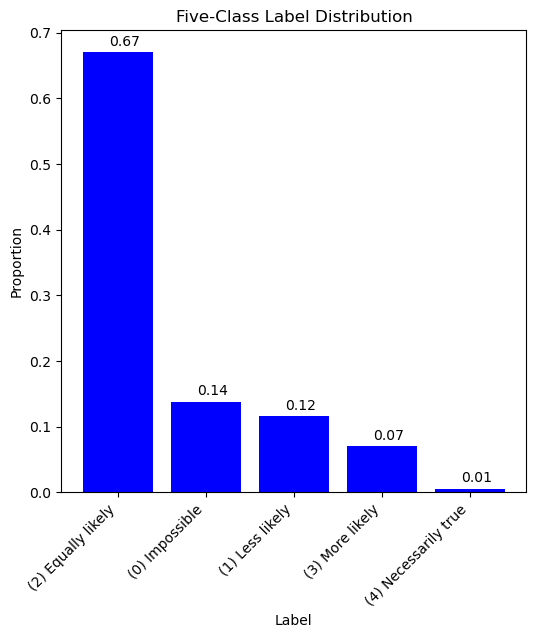


                               Label counts  Label proportions
label_strings                                                 
(0) Equally likely                    10805           0.670493
(-1) Decrease in plausibility          4089           0.253739
(1) Increase in plausibility           1221           0.075768


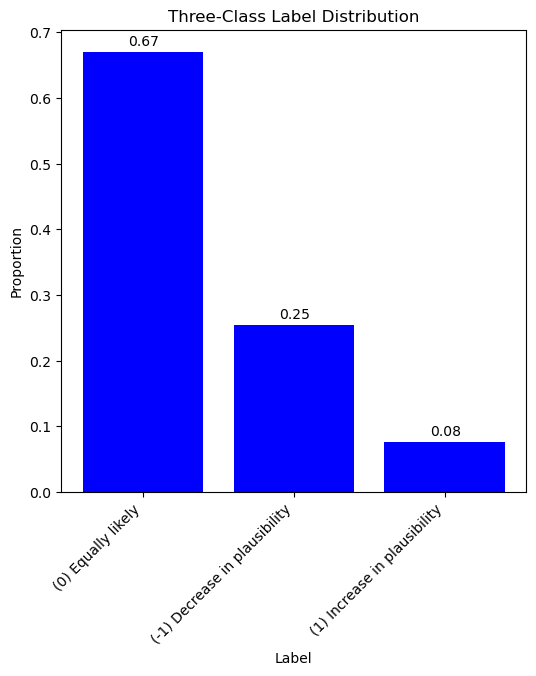

In [8]:
label_dstribution(combined_df, five_class_label, "Five-Class Label Distribution")
label_dstribution(combined_df, three_class_label, "Three-Class Label Distribution")

### Discussion: Label Distribution
- 5-Class: The labels are highly imbalanced, with "Equally likely" representing up to 0.67 and only 0.01 for "Necessarily true."
- 3-Class: 
    - Labels are groupped similar to the original paper, that "(0) Impossible" and "(1) Less likely" are mapped to "Decrease in plausibility," while "(3) More likely" and "(4) Necessarily true" are mapped to "Increase in plausibility." 
    - "Equally likely" still has the largest proportion, followed by "Decrease in plausibility" and "Increase in plausibility."

## Modifiers Rank-Frequency Distribution

In [9]:
def compute_modifiers(df):
    
    # 1. Counting numbers of unique modifiers and the print the top 10 frequent modifiers.
    print(f"\n----- MODIFIERS -----")
    num_unique_modifiers = len(df["modifier"].unique())
    print(f"Counts of unique modifiers: {num_unique_modifiers}")
    unique_modifier_counts = df["modifier"].value_counts()
    sorted_modifiers = unique_modifier_counts.sort_values(ascending=False)
    print(f"\nTop 10 frequent modifiers and their counts: \n{sorted_modifiers[:10]}")
    
    # 2. Plot frequency and ranking for unique modifiers.
    counts_df = pd.DataFrame({
        "modifier": sorted_modifiers.index,
        "count": sorted_modifiers.values
    })
    counts_df["ranking"] = counts_df["count"].rank(ascending=False, method="dense")
    plt.figure()
    colors = counts_df["count"]
    plt.scatter(counts_df["ranking"], counts_df["count"], c=colors, alpha= 0.3)
    plt.xlabel('Ranking (descending order of counts)')
    plt.ylabel('Counts')
    plt.title('Unique Modifiers Rank-Frequency Distribution')
    plt.show()
    
    return None


----- MODIFIERS -----
Counts of unique modifiers: 3151

Top 10 frequent modifiers and their counts: 
modifier
virtual       486
former        438
dead          367
fake          248
artificial    238
historic      221
false         215
future        189
potential     189
new           186
Name: count, dtype: int64


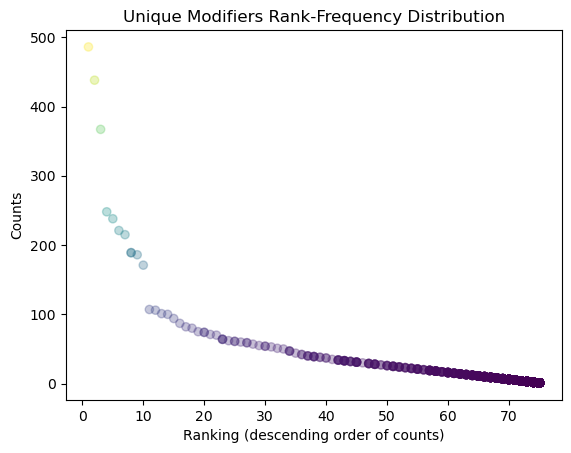

In [10]:
compute_modifiers(combined_df)

### Discussion: Unique Modifiers Rank-Frequency Distribution
- The top 10 frequent modifiers (from the yellow to blue dots) have much higher frequencies than the rest (the purple dots).
- Long tail: The stronger color in the tail demonstrates that many modifiers occur only once.

## Investigate Modifier-Noun Pairs
Next we are going to look at the top 10 mod-n pairs across all classes as well as two extremes, i.e., in the "Impossible" and "Necessarily true" classes.

In [11]:
def count_freq_and_top10_pairs(df):
    """
    Count the frequency and determine the top 10 ranking of Modifier-Noun pairs based on their counts.
    """
    pair_counts = df.groupby(["modifier","noun"]).size().reset_index(name="pair_counts")
    sorted_pair_counts = pair_counts.sort_values(by="pair_counts", ascending=False)
    top10_pairs = sorted_pair_counts.head(10)
    pair_counts_with_label = pd.merge(df[['modifier', 'noun', 'label']], pair_counts, on=['modifier', 'noun'])
    label_counts = pair_counts_with_label.groupby(["modifier", "noun", "label"]).size().reset_index(name="label_counts")
    label_counts_pivot = label_counts.pivot_table(index=["modifier", "noun"], columns="label", values="label_counts", fill_value=0).reset_index()
    label_counts_pivot_filtered = label_counts_pivot[label_counts_pivot[['modifier', 'noun']].apply(tuple, axis=1).isin(top10_pairs[['modifier', 'noun']].apply(tuple, axis=1))]
    label_counts_pivot_filtered = label_counts_pivot_filtered.set_index(['modifier', 'noun']).reindex(index=top10_pairs.set_index(['modifier', 'noun']).index).reset_index()
    return top10_pairs, label_counts_pivot_filtered

In [12]:
# display overall top 10 pairs
overall_top10_pairs, label_counts_pivot = count_freq_and_top10_pairs(combined_df)
print(f'\nTop 10 frequent pairs and their counts:')
overall_top10_pairs


Top 10 frequent pairs and their counts:


,modifier,noun,pair_counts
3789,false,milk,10
8064,old,graveyard,8
5159,great,banjo,7
2623,deputy,secretary,7
3761,false,food,7
3676,fake,menu,7
3654,fake,gun,7
12604,virtual,calendar,7
1415,certified,grocer,7
6556,likely,comb,6


In [13]:
label_counts_pivot

label,modifier,noun,0,1,2,3,4
0,false,milk,6.0,3.0,1.0,0.0,0.0
1,old,graveyard,0.0,0.0,6.0,2.0,0.0
2,great,banjo,0.0,0.0,6.0,0.0,1.0
3,deputy,secretary,0.0,0.0,6.0,1.0,0.0
4,false,food,1.0,6.0,0.0,0.0,0.0
5,fake,menu,1.0,6.0,0.0,0.0,0.0
6,fake,gun,1.0,4.0,2.0,0.0,0.0
7,virtual,calendar,0.0,0.0,7.0,0.0,0.0
8,certified,grocer,0.0,0.0,6.0,1.0,0.0
9,likely,comb,2.0,0.0,4.0,0.0,0.0


### Top 10 frequent pairs across labels
- Among the top 10 pairs, 6 of them are primarily labeled as "Equally likely" (2), and 4 of them are labeled as "Decrease in plausibility" (0, 1).

- **Non-subsective adjectives** (according to the non-subsective adjective list from [Stanford HCI Group](https://hci.stanford.edu/cstr/reports/2014-04.pdf)): "false," "fake," "deputy," "virtual," and "likely," are non-subsective adjectives. Among them, **"false" and "fake" are most often labeled as "Decrease in plausibility."** The inplausibility sometimes comes from the pair itself being an invalid expression, such as "false milk" and "false food".

In [14]:
def count_top10_pairs_for_class(label=int):
    original_class_df = combined_df[combined_df['label'] == label]
    class_df = original_class_df.groupby(['modifier', 'noun']).size().reset_index(name='pair_counts')
    top10_pairs = class_df.sort_values(by='pair_counts', ascending=False).head(10)
    top10_pairs = pd.merge(top10_pairs, original_class_df[['modifier', 'noun', 'sentence1', 'sentence2']], on=['modifier', 'noun'], how='left').drop_duplicates()
    return top10_pairs

In [15]:
# display top 10 pairs for class "Impossible"
print(f'\nTop 10 frequent pairs, counts and sentences in class "Impossible":')
count_top10_pairs_for_class(label=0)


Top 10 frequent pairs, counts and sentences in class "Impossible":


,modifier,noun,pair_counts,sentence1,sentence2
0,false,milk,6,Milk is purchased from a corner grocery.,False milk is purchased from a corner grocery.
1,false,milk,6,Milk is pasteurized for human consumption.,False milk is pasteurized for human consumption.
2,false,milk,6,Milk is used in a recipe.,False milk is used in a recipe.
3,false,milk,6,Milk comes from mammals.,False milk comes from mammals.
4,false,milk,6,Milk is produced by mammals.,False milk is produced by mammals.
5,false,milk,6,Milk is produced by a female cow.,False milk is produced by a female cow.
6,dead,radio,6,You use a radio to hear news.,You use a dead radio to hear news.
7,dead,radio,6,You use a radio to follow the stock market.,You use a dead radio to follow the stock market.
8,dead,radio,6,You use a radio to call in on a talk show.,You use a dead radio to call in on a talk show.
9,dead,radio,6,A radio is used for listening the news.,A dead radio is used for listening the news.


### Top 10 frequent pairs in the class "Impossible"
- There are multiple duplicated pairs in the 'Impossible' class, which may contribute to making this class the second-largest across all classes.
- **All** modifiers in the top 10 pairs are **non-subsective adjectives**.
- The inplausibility of valid expressions, such as 'dead cat,' 'dead mouse,' and 'dead dog,' are influenced by the context, specifically a conflict between the modifier-noun pair and the verb, e.g., 'A dead mouse eats grain.'

In [16]:
# display top 10 pairs for class "Necessarily true"
print(f'\nTop 10 frequent pairs, counts and sentences in class "Necessarily true":')
count_top10_pairs_for_class(label=4)


Top 10 frequent pairs, counts and sentences in class "Necessarily true":


,modifier,noun,pair_counts,sentence1,sentence2
0,dead,duck,3,A duck is roasted.,A dead duck is roasted.
1,dead,duck,3,You use a duck to make duck a l'orange.,You use a dead duck to make duck a l'orange.
2,dead,duck,3,A duck is eaten.,A dead duck is eaten.
3,aerobic,fermentation,1,Fermentation converts sugar to alcohol.,Aerobic fermentation converts sugar to alcohol.
4,real,bread,1,Bread is high in carbohydrates.,Real bread is high in carbohydrates.
5,possible,everything,1,Everything is made out of atoms.,Possible everything is made out of atoms.
6,perfect,umbrella,1,An umbrella is for keeping the sun off you.,A perfect umbrella is for keeping the sun off ...
7,past,game,1,A game is over.,A past game is over.
8,past,century,1,A century lasts one hundred years.,A past century lasts one hundred years.
9,new,explosive,1,You use an explosive to blow things or people up.,You use a new explosive to blow things or peop...


### Top 10 frequent pairs in class "Necessarily true"
- There are way less duplicated pairs compared with the class "Impossible".
- Non-subsective adjectives such as 'dead,' 'possible,' and 'past' still exist in this class, suggesting that **non-subsective adjectives have the capability to make events more or less possible**.
- The presence of "dead" in both "Impossible" and "Necessarily true" suggests that **only relying on taxonomy to judge plausibility is insufficient. Context should also be considered, specifically whether the modifier-noun pair is valid with the predicate.**

## Label Distribution of Concreteness of Modifiers
We use concreteness ratings ([Brysbaert 2013](https://link.springer.com/article/10.3758/s13428-013-0403-5)) to investigate the concretness of modifiers in ADEPT.
 
As the 5-class labels are inbalanced, we use 3-class labels here.

In [17]:
# read the concreteness ratings as pandas dataframe
concrete_df = pd.read_excel(concrete_path)
concrete_df = concrete_df[["Word", "Conc.M"]]
concrete_df.head()

,Word,Conc.M
0,a,1.46
1,aardvark,4.68
2,aback,1.65
3,abacus,4.52
4,abandon,2.54


In [18]:
merged_df = pd.merge(combined_df, concrete_df, left_on='modifier', right_on='Word', how='left')
merged_df = merged_df.drop(columns=['Word'])
combined_df = merged_df.rename(columns={'Conc.M': 'conc_rating'})
combined_df

,sentence1,sentence2,modifier,noun,label,idx,dataset,label_strings,conc_rating
0,The effect of sleeping is rejuvenation.,The effect of additional sleeping is rejuvenat...,additional,sleeping,3,13484,train,(1) Increase in plausibility,2.43
1,A toothbrush is for fresh breath.,A regular toothbrush is for fresh breath.,regular,toothbrush,2,2620,train,(0) Equally likely,2.40
2,A scene is painted.,A negative scene is painted.,negative,scene,2,3324,train,(0) Equally likely,1.79
3,A bone breaks a tooth.,An alleged bone breaks a tooth.,alleged,bone,2,10610,train,(0) Equally likely,1.82
4,A trip causes a happening.,A fabulous trip causes a happening.,fabulous,trip,2,14917,train,(0) Equally likely,2.12
...,...,...,...,...,...,...,...,...,...
16110,A heater is used in the winter.,A hot heater is used in the winter.,hot,heater,2,12858,test,(0) Equally likely,4.31
16111,You use a tin to make ornaments.,You use a convenient tin to make ornaments.,convenient,tin,2,14438,test,(0) Equally likely,1.85
16112,A table is for writing at it.,A quarterly table is for writing at it.,quarterly,table,0,4931,test,(-1) Decrease in plausibility,2.29
16113,A dollar equals four quarters.,A millionth dollar equals four quarters.,millionth,dollar,0,9189,test,(-1) Decrease in plausibility,2.70


In [19]:
# Check if there are any NaN or 0.00 values
nan = combined_df['conc_rating'].isna()
zero_values = (combined_df['conc_rating'] == 0.00)

if nan.any() or zero_values.any():
    print("There are NaN or 0.00 values in the 'conc_rating' column.")
    print(f"Number of NaN values: {nan.sum()}")
    print(f"Number of 0.00 values: {zero_values.sum()}")
else:
    print("There are no NaN or 0.00 values in the 'conc_rating' column.")

There are NaN or 0.00 values in the 'conc_rating' column.
Number of NaN values: 1173
Number of 0.00 values: 0


In [20]:
# mapping float values to 3 concreteness classes: -1 -> "abstract", 0 -> "mid", 1 -> "concrete"
def map_conc_rating(value):
    if pd.notna(value):
        if 0 < value < 2:
            return -1
        elif 2 <= value < 4:
            return 0
        elif value >= 4:
            return 1
    return value

combined_df['conc_rating_mapped'] = combined_df['conc_rating'].apply(map_conc_rating)
combined_df = combined_df.rename(columns={'label_strings': 'label_3_class'})
combined_df[['modifier','label_3_class','conc_rating_mapped']]

,modifier,label_3_class,conc_rating_mapped
0,additional,(1) Increase in plausibility,0.0
1,regular,(0) Equally likely,0.0
2,negative,(0) Equally likely,-1.0
3,alleged,(0) Equally likely,-1.0
4,fabulous,(0) Equally likely,0.0
...,...,...,...
16110,hot,(0) Equally likely,1.0
16111,convenient,(0) Equally likely,-1.0
16112,quarterly,(-1) Decrease in plausibility,0.0
16113,millionth,(-1) Decrease in plausibility,0.0


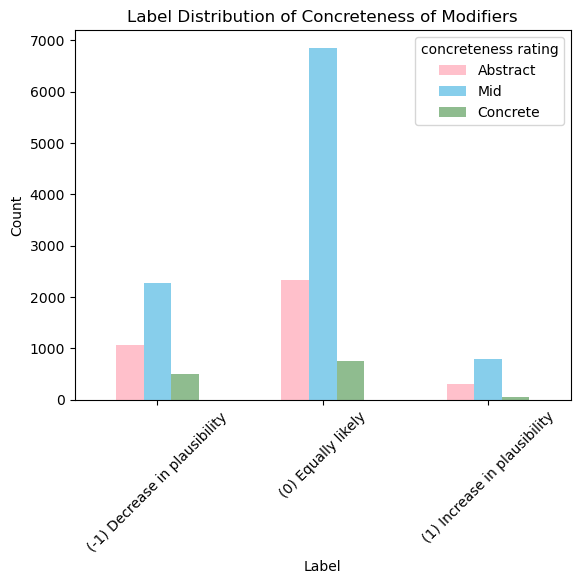

In [21]:
# for each label, count numbers of -1, 0, 1 in conc_rating_mapped
counts_df = combined_df.groupby(['label_3_class', 'conc_rating_mapped']).size().unstack(fill_value=0)

# Plot grouped bar chart with subplots
counts_df.plot(kind='bar', color=['pink', 'skyblue', 'darkseagreen'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution of Concreteness of Modifiers')
plt.xticks(rotation=45)
plt.legend(title = 'concreteness rating', labels = ['Abstract', 'Mid', 'Concrete'])
plt.show()

### Discussion: Label Distribution of Concreteness of Modifiers
- The overall trend of concreteness is similar across all three labels, with "Mid-level" concreteness being the most prominent, followed by "Abstract," and then "Concrete."
- However, the proportion of "Concrete" in the class "Decrease in plausibility" is not much less than in the class "Equally likely," compared to the "Mid-level" group where we can observe a sharp decrease. This **indicates that modifiers that are more concrete may have a greater impact on decreasing plausibility**, aligning with Eichel and Schulte im Walde 2023.